I told myself I wouldn't do it again. The [last time]({{< ref "blog/optimal-peanut-butter-and-banana" >}}) nearly broke me. And yet, [just when I thought I was out, they pull me back in](https://www.youtube.com/watch?v=G29DXfcdhBg). 

Against my better judgement, I did another sandwich data science project. Thankfully, this one was significantly simpler.

## An Impenetrable Menu

I work at [Square](https://squareup.com/), and their NYC office is in SoHo. While there are many reasons not to go into the office nowadays, one draw is that I can pick up lunch at [Alidoro](https://www.alidoronyc.com/), a tiny Italian sandwich shop that's nearby. The sandwiches are the quintissential European antithesis to American sandwiches; they consist of only a couple, extremely high quality ingredients.

From these few ingredients emerge 40 different types of sandwiches, and these 40 sandwiches form an impenetrable menu.

<img style='width: 640px; padding: 10px'  src='images/sandmat/alidoro_menu.jpg' />

Naively, you may think you can pick a sandwich that looks close to what you want and then customize it. Perhaps you would like the Romeo but with some fresh mozzarella? Well then perhaps you would be wrong because _customization is not allowed_. Did I mention that Alidoro definitely has similar vibes to the [Soup Nazi](https://youtu.be/euLQOQNVzgY)? You can only order what's on the menu, and it took the global pandemic to finally break their will to remain cash only.

Some people like to explore new items on a menu, while I always exploit the one that I've been happy with. Case in point: I get the Fellini on Foccacia every time. Still, I remember what it was like to be a newcomer and encounter that impenetrable menu. 

And so, this blog post is my attempt at data visualization. My goal is to visualize the menu in such a way that one can quickly scan it to find a sandwich they would like. As an added bonus, I'll close with some statistical modeling of the sandwich pricing.

## Menu Scraping

To start, we need to get the menu and turn it into "data". For whatever reason, I didn't feel like using pandas for this blog post, so everything we'll deal with are collections of [dataclasses](https://docs.python.org/3/library/dataclasses.html). 

_By the way, I'm purposefully being super pedantic below and creating lots of functions for every thing. Sure, I could do the scraping as one big long script, but breaking everything up into individual functions for each piece of data that we want to collect is a lesson in building maintainable code which is particularly important when dealing with web scraping. Am I going to be rerunning this code after I publish this? God no. But hey, the pedagogy remains._


I'll start with some library imports and defining two `dataclasses`: `Ingredient` and `Sandwich`. Each `Ingredient` has both a `name` and a `category`, where the possible categories are `meat`, `cheese`, `topping`, and `dressing`. Each `Sandwich` contains a `name`, a list of `Ingredients`, and a `price`.

In [1]:
%config InlineBackend.figure_format = 'retina'

from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple
from urllib.request import urlopen

from bs4 import BeautifulSoup, Tag
import altair as alt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
@dataclass(frozen=True)
class Ingredient:
    name: str
    category: str


@dataclass(frozen=True)
class Sandwich:
    name: str
    ingredients: Tuple[Ingredient]
    price: float

In keeping with the pedantry, I'll show you the final function that we want to assemble, and then work our way towards it:

```python
def get_sandwiches(url: str) -> List[Sandwich]:
    soup = BeautifulSoup(urlopen(url))
    menu = get_sandwich_menu(soup)
    sandwich_tags = get_sandwich_tags(menu)
    sandwiches = [convert_sandwich_tag_to_sandwich(sandwich_tag) for sandwich_tag in sandwich_tags]
    return sandwiches
```

We're going to use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape the [menu page](https://www.alidoronyc.com/menu/menu/) of the Alidoro website and grab the section of the HTML that pertains to the menu. Assuming we've turned that page into a `Beautiful Soup` object, the following function will pick out the menu section and return the `Beautiful Soup` `Tag` object associated with the menu HTML tag.

In [3]:
def get_sandwich_menu(soup: BeautifulSoup) -> Tag:
    sections = soup.find_all(name="section", **{"class": "menu-section"})
    menu = None
    for section in sections:
        if section.find("h2").text == "Menu":
            menu = section

    if menu is None:
        raise ValueError("Cannot find Sandwich section of menu.")
    return menu

Once we have the menu, the next step is to grab each sandwich `Tag`.

In [4]:
def get_sandwich_tags(menu: Tag) -> Iterable[Tag]:
    return menu.find_all(name="li", **{"class": "menu-item"})

With the sandwich `Tags` in hand, we'll write functions to parse each field of the `Sandwich` `dataclass`. We start with the `name` and the `price`.

In [5]:
def get_sandwich_name(sandwich_tag: Tag) -> str:
    return sandwich_tag.find(name="p", **{"class": "menu-item__heading"}).text

In [6]:
def get_sandwich_price(sandwich_tag: Tag) -> float:
    price = sandwich_tag.find(name="p", **{"class": "menu-item__details--price"}).text
    price = float(price.strip(" $\n"))
    return price

Parsing the `ingredients` is a little more complicated because we need to write two helper functions. First, some of the ingredient names need to be cleaned up and deduplicated.

In [7]:
def cleanup_ingredient(name: str) -> str:
    name = name.lower()
    mapper = {
        "m. bel paese cheese": "m. bel paese",
        "arugul": "arugula",
        "artichoke": "artichokes",
        "sweet roasted pepper": "sweet roasted peppers",
        "olive past": "olive paste",
    }
    return mapper.get(name, name)

Second, we need to assign categories to each ingredient

In [8]:
def categorize_ingredient(name: str) -> str:
    mapper = {
        "artichokes": "topping",
        "arugula": "topping",
        "capicollo": "meat",
        "caponata of eggplant": "topping",
        "dressing": "dressing",
        "fresh mozzarella": "cheese",
        "hot peppers": "topping",
        "m. bel paese": "cheese",
        "mortadella": "meat",
        "olive paste": "dressing",
        "prosciutto": "meat",
        "provolone cheese": "cheese",
        "salami": "meat",
        "sardines or mackerel": "meat",
        "smoked chicken breast": "meat",
        "smoked mozzarella": "cheese",
        "sopressata": "meat",
        "sun dried tomatoes": "topping",
        "sweet roasted peppers": "topping",
        "tuna": "meat",
    }
    try:
        return mapper[name]
    except KeyError:
        raise ValueError(f"Category not found for ingredient {name!r}")
        
        

We can now write the function to assemble the `ingredients`.

In [9]:
def get_sandwich_ingredients(sandwich_tag: Tag) -> Tuple[Ingredient]:
    other_paragraphs = sandwich_tag.find_all(name="p")
    ingredients = None
    for p in other_paragraphs:
        if not p.get("class"):
            ingredients = p.text.split(", ")
            ingredients = [cleanup_ingredient(ingredient) for ingredient in ingredients]
            ingredients = tuple(
                [
                    Ingredient(
                        name=ingredient, category=categorize_ingredient(ingredient)
                    )
                    for ingredient in ingredients
                ]
            )
    if ingredients is None:
        raise ValueError(f"Cannot parse ingredients for sandwich {name}")
    return ingredients

With all of the individual components to the `Sandwich` defined, we write a "pipeline" function to assemble the full `Sandwich`.

In [10]:
def convert_sandwich_tag_to_sandwich(sandwich_tag: Tag) -> Sandwich:
    name = get_sandwich_name(sandwich_tag)
    ingredients = get_sandwich_ingredients(sandwich_tag)
    price = get_sandwich_price(sandwich_tag)
    return Sandwich(name, ingredients, price)

And then finally, we can define that initial function to scrape and assemble all of the sandwiches.

In [11]:
def get_sandwiches(url: str) -> List[Sandwich]:
    soup = BeautifulSoup(urlopen(url))
    menu = get_sandwich_menu(soup)
    sandwich_tags = get_sandwich_tags(menu)
    sandwiches = [convert_sandwich_tag_to_sandwich(sandwich_tag) for sandwich_tag in sandwich_tags]
    return sandwiches

In [12]:
URL = "https://www.alidoronyc.com/menu/menu/"

In [13]:
sandwiches = get_sandwiches(URL)

In [14]:
print(sandwiches[0])

Sandwich(name='Matthew', ingredients=(Ingredient(name='prosciutto', category='meat'), Ingredient(name='fresh mozzarella', category='cheese'), Ingredient(name='dressing', category='dressing'), Ingredient(name='arugula', category='topping')), price=14.0)


## Ingredient Rank and File

I would like to display the sandwiches in "matrix" form. Each sandwich will be a row, each ingredient will be a column, and I will indicate if a sandwich has a particular ingredient. What's left is to decide on an order to the sandwich rows and an order to the ingredient columns.

In my initial approach, I coded up a "Traveling Sandwich Problem" in which sandwiches were cities, and the overlap in ingredients between any two sandwiches was the "distance" between sandwiches. It would've made for a cute title, but, contrary to the numerical solution, the result was visually suboptimal.

Thankfully, this is a problem where we can rely on domain expertise. As a sandwich eater myself, I thought about how I typically pick a sandwich. I often look at the meats first, then the cheeses, and then everything else. Ok, let's sort the ingredient columns by category "rank": `meat`, `cheese`, `topping`, `dressing`. Within each category, how about the recsys go-to of sorting in descending order of popularity? Combining category rank and popularity gives us our full ingredient column order. In SQL, we'd want to do something like

```mysql
SELECT
  category
  , CASE 
    WHEN category = 'meat' THEN 1
    WHEN category = 'cheese' THEN 2
    WHEN cateogry = 'topping' THEN 3
    WHEN category = 'dressing' THEN 4
  END AS category_rank
  , ingredient
  , COUNT(DISTINCT sandwich) as num_sandwiches
FROM sandwich_ingredients
GROUP BY category, category_rank, ingredient
ORDER BY category_rank ASC, num_sandwiches DESC
```

In Python, we can do the following to compose an ordered dictionary where the key is the ingredient name, and the value is the `Ingredient` dataclass.

In [15]:
def get_ranked_categories(
    sandwiches: List[Sandwich],
) -> Dict[str, Dict[Ingredient, int]]:
    """
    Group ingredients by category and order them by how many sandwiches
    the ingredient is in.

    For ranked_categories, the key is the category name (e.g. 'meat'),
    and the value is an ordered dict where key is Ingredient and value
    is the number of the sandwiches this ingredient is in (i.e. the "ingredient rank").
    The dict is in descending order of ingredient rank.
    """
    category_order = ["meat", "cheese", "topping", "dressing"]

    category_counts = defaultdict(Counter)
    for sandwich in sandwiches:
        for ingredient in sandwich.ingredients:
            category_counts[ingredient.category].update([ingredient])

    # Dicts in Python 3.7+ are ordered based on insertion order.
    # Thus, iterating through ranked_categories will iterate in
    # the order of category_order
    ranked_categories = {}
    for category in category_order:
        ranked_categories[category] = {
            ingredient: rank
            for rank, (ingredient, count) in enumerate(
                category_counts[category].most_common(), start=1
            )
        }
    return ranked_categories

In [16]:
ranked_categories = get_ranked_categories(sandwiches)

In [17]:
# We rely on the fact that dicts are ordered by insertion order,
# so iterating through ordered_ingredients will iterate through
# the ingredients by category order and then ingredient rank.
ordered_ingredients: Dict[str, Ingredient] = {}
for category, ingredients in ranked_categories.items():
    for ingredient in ingredients:
        ordered_ingredients[ingredient.name] = ingredient

For ordering our sandwich rows, let's sort them by `key` which is a tuple that contains their most popular ingredient in each category where the tuple is in order of `meat`, `cheese`, `topping`, `dressing`.

In [18]:
def sort_key(
    sandwich: Sandwich, ranked_categories: Dict[str, Ingredient]
) -> Tuple[int, ...]:
    """
    Given a sandwich, return a key to sort this sandwich with respect to.
    The key is a tuple of ingredient ranks where there is a different
    element of the tuple for each category. This allows for sorting on
    multiple fields i.e. sort by meat, then cheese, then topping,
    then dressing.
    """
    sortings = []
    for category, ranked_ingredients in ranked_categories.items():
        ranks = [
            ranked_ingredients[i]
            for i in sandwich.ingredients
            if i in ranked_ingredients
        ]
        if ranks:
            category_rank = min(ranks)
        else:
            # No sandwich ingredients from this category.
            # Set rank to max rank + 1 for the category
            category_rank = len(ranked_ingredients) + 1
        sortings.append(category_rank)
    return tuple(sortings)


ordered_sandwiches = sorted(
    sandwiches, key=lambda sandwich: sort_key(sandwich, ranked_categories)
)

## Visualizing the Matrix

Finally, with our ordered ingredients and sandwiches, we can visualize the Alidoro sandwich menu as a matrix. Let's first construct our sandwich matrix and then write some visualization functions.

In [19]:
# Make matrix where rows are sandwiches and columns are ingredients.
# Values are 1 if sandwich has the ingredient and 0 otherwise.
sandwich_mat = np.zeros((len(ordered_sandwiches), len(ordered_ingredients)))
sandwich_to_idx = {sandwich: idx for idx, sandwich in enumerate(ordered_sandwiches)}
ingredient_to_idx = {
    ingredient: idx for idx, ingredient in enumerate(ordered_ingredients.values())
}
for sandwich in ordered_sandwiches:
    for ingredient in sandwich.ingredients:
        sandwich_mat[sandwich_to_idx[sandwich], ingredient_to_idx[ingredient]] = 1

In [20]:
def column_colors(ordered_ingredients: dict):
    color_mapper = {
        "meat": "red",
        "cheese": "orange",
        "topping": "green",
        "dressing": "purple",
    }
    return np.array([color_mapper[i.category] for i in ordered_ingredients.values()])

In [21]:
def plot_sandwiches(sandwich_mat, ordered_sandwiches, ordered_ingredients):

    fig, ax = plt.subplots(figsize=(10, 20))
    xs, ys = np.where(sandwich_mat)
    colors = column_colors(ordered_ingredients)

    ax.scatter(x=ys, y=xs, marker="x", c=colors[ys])
    ax.set_yticks(np.arange(len(sandwich_mat)))
    ax.set_yticklabels([s.name for s in ordered_sandwiches], fontsize=12)
    ax.tick_params(length=0)
    ax.set_xticks(np.arange(sandwich_mat.shape[1]))
    ax.set_xticklabels(
        list(ordered_ingredients.keys()), rotation=45, ha="left", fontsize=12
    )
    ax.xaxis.tick_top()

    for i in range(-1, len(sandwich_mat)):
        ax.plot(
            (-0.5, sandwich_mat.shape[1] + 0.5),
            (0.5 + i, 0.5 + i),
            c="gray",
            alpha=0.5,
            linestyle="dashed",
            linewidth=0.5,
        )

    ax.set_xlim((-0.5, sandwich_mat.shape[1]))

    for i in range(-1, len(sandwich_mat)):
        ax.plot(
            (0.5 + i, 0.5 + i),
            (-0.5, sandwich_mat.shape[0] + 0.5),
            c="gray",
            alpha=0.5,
            linestyle="dashed",
            linewidth=0.5,
        )
    ax.set_ylim(-0.5, len(sandwich_mat) - 0.5)
    # ax.grid(b=True, which="both");
    ax.invert_yaxis()

    for color, tick in zip(colors, ax.get_xticklabels()):
        tick.set_color(color)
    return fig, ax

### _[Ed ecco qua](https://translate.google.com/?sl=auto&tl=it&text=et%20voila&op=translate&hl=en)_ 

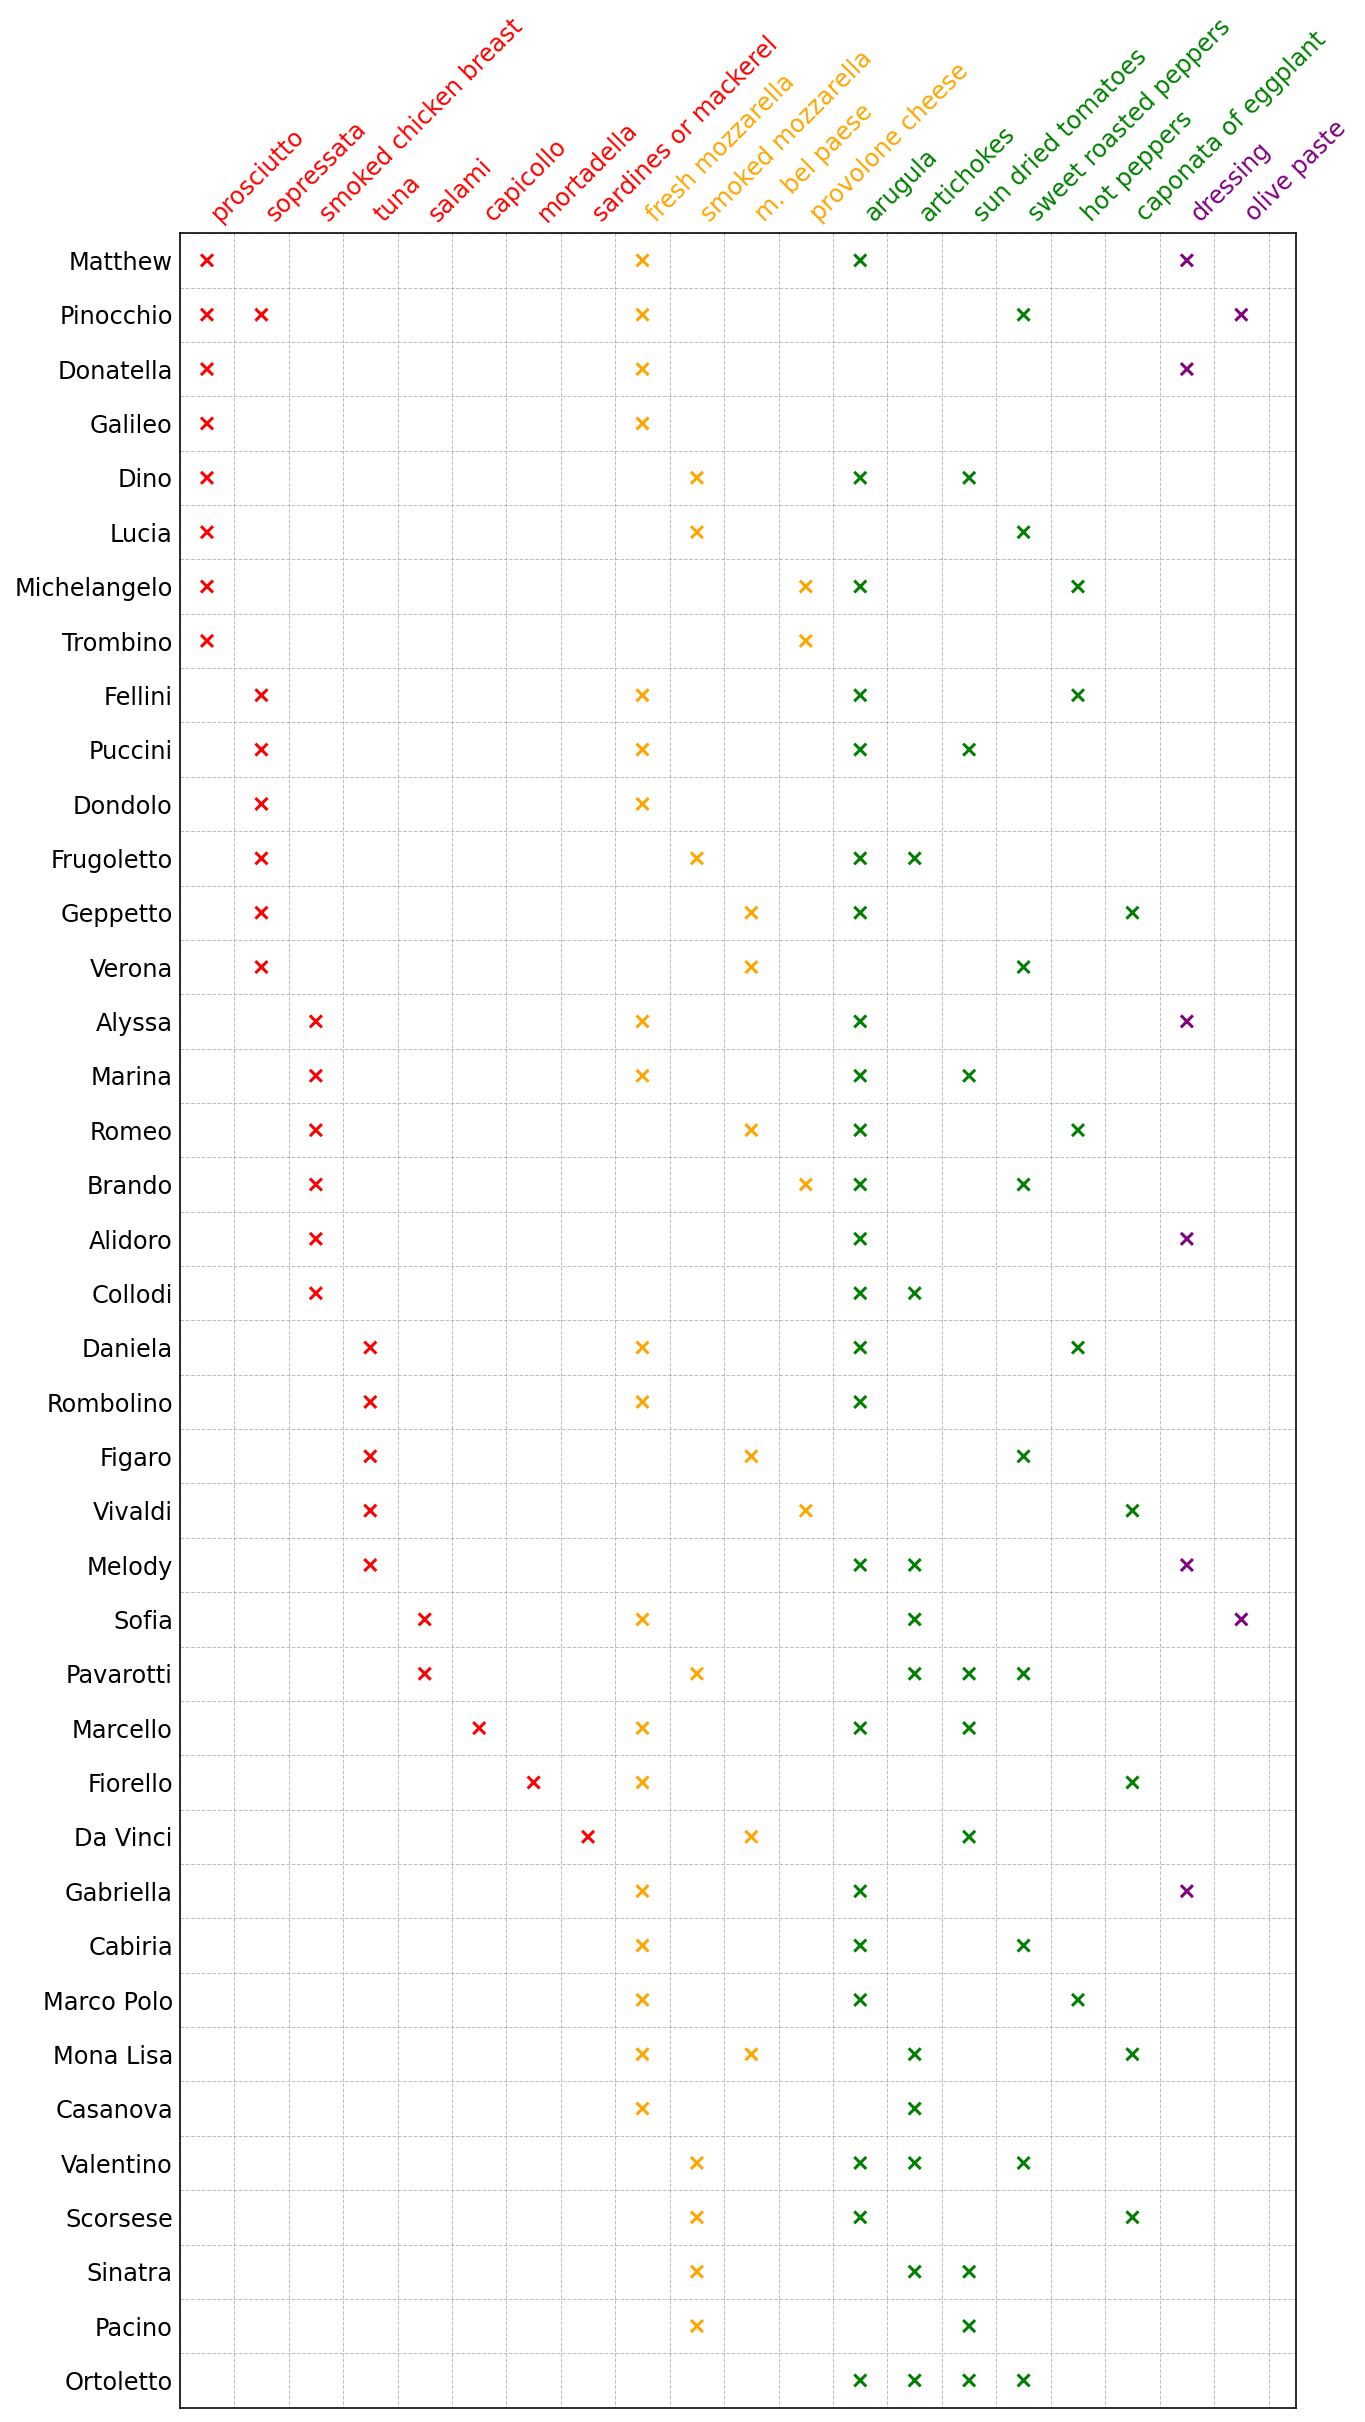

In [22]:
fig, ax = plot_sandwiches(sandwich_mat, ordered_sandwiches, ordered_ingredients)
plt.show();

# Pricing Analysis

Just for prosciuttos and giggles, let's fit a linear regression where each row is a sandwich, the "features" are binary indicators of whether or not an ingredient is present in the sandwich, and the target variable is the sandwich price. The coefficients will thus be the price of each ingredient, and a bias term will take care of the base price of the sandwich (which includes the bread). As you can see, the model is pretty well-calibrated! I guess Alidoro's sandwich pricing is pretty consistent.

In [23]:
import statsmodels.api as sm

In [24]:
y = np.array([sandwich.price for sandwich in ordered_sandwiches])
X = sandwich_mat.copy()

X = sm.add_constant(X, prepend=True)

model = sm.OLS(y, X)
res = model.fit()

In [25]:
res.summary(
    yname="Price ($)", xname=["Base Sandwich Price"] + list(ordered_ingredients)
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price ($)   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     31.39
Date:                Sat, 25 Sep 2021   Prob (F-statistic):           1.48e-10
Time:                        22:13:39   Log-Likelihood:                 9.6979
No. Observations:                  40   AIC:                             22.60
Df Residuals:                      19   BIC:                             58.07
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Base Sandwich Price       8.0451      0.265     30.334      0.000       7.490       8.600
prosciutto                2.1138      0.166     12.769      0.000       1.767       2.460
sopressata                1.9554      0.152     12.875      0.000       1.638       2.273
smoked chicken breast     2.0618      0.182     11.323      0.000       1.681       2.443
tuna                      1.7025      0.171      9.940      0.000       1.344       2.061
salami                    2.1288      0.279      7.641      0.000       1.546       2.712
capicollo                 2.0982      0.327      6.421      0.000       1.414       2.782
mortadella                3.0738      0.359      8.573      0.000       2.323       3.824
sardines or mackerel      2.4387      0.375      6.497      0.000       1.653       3.224
fresh mozzarella          1.3168      0.174      7.581      0.000       0.953       1.680
smoked mozzarella         1.3141      0.210      6.271      0.000       0.875       1.753
m. bel paese              1.2748      0.223      5.707      0.000       0.807       1.742
provolone cheese          1.3559      0.250      5.429      0.000       0.833       1.879
arugula                   1.2985      0.129     10.076      0.000       1.029       1.568
artichokes                1.2708      0.140      9.074      0.000       0.978       1.564
sun dried tomatoes        1.2414      0.147      8.458      0.000       0.934       1.549
sweet roasted peppers     1.1692      0.135      8.637      0.000       0.886       1.453
hot peppers               1.0734      0.183      5.850      0.000       0.689       1.458
caponata of eggplant      1.0643      0.210      5.074      0.000       0.625       1.503
dressing                  1.0242      0.172      5.963      0.000       0.665       1.384
olive paste               0.5690      0.285      1.998      0.060      -0.027       1.165
==============================================================================
Omnibus:                       14.030   Durbin-Watson:                   2.450
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.010
Skew:                          -1.089   Prob(JB):                     0.000202
Kurtosis:                       5.337   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can inspect this model visually by plotting the prices of all of the ingredients. I had no idea mortadella was the most expensive meat.

In [29]:
data = {
    "values": [
        {
            "x": x,
            "Ingredient": ingredient.name,
            "Price": price,
            "Category": ingredient.category,
            "SE": se,
        }
        for x, (ingredient, price, se) in enumerate(
            zip(list(ordered_ingredients.values()), res.params[1:], res.bse[1:])
        )
    ]
}

In [30]:
color_mapper = {
    "meat": "red",
    "cheese": "orange",
    "topping": "green",
    "dressing": "purple",
}
scale = alt.Scale(domain=list(color_mapper.keys()), range=list(color_mapper.values()))

In [31]:
chart = (
    alt.Chart(data)
    .mark_bar(opacity=0.5)
    .encode(
        x=alt.X("Price:Q", axis=alt.Axis(format="$.2f")),
        y=alt.Y("Ingredient:N", sort="-x"),
        color=alt.Color("Category:N", scale=scale),
        tooltip=[
            "Ingredient:N",
            alt.Tooltip("Price:Q", format="$.2f"),
            alt.Tooltip("SE:Q", format="$.2f", title="Standard Error"),
        ],
    )
)

In [32]:
chart

alt.Chart(...)

And last, but not least, we can compare the sandwich price to the model's predicted price in order to get an idea if any sandwich's price is wildly inconsistent. That doesn't appear to be the case, although the Gabriella is apparently cheaper than expected at $11.00 for (only) fresh mozzarella, dressing, and arugula. I don't know if I'd call that cheap, but, then again, neither is SoHo.

In [26]:
y_pred = model.predict(res.params)

In [27]:
data = {
    "values": [
        {
            "Price": price,
            "Prediction": prediction,
            "Sandwich": sandwich.name,
            "Ingredients": ", ".join(
                ingredient.name for ingredient in sandwich.ingredients
            ),
            "Vegetarian": all(
                ingredient.category != "meat" for ingredient in sandwich.ingredients
            ),
        }
        for (price, prediction, sandwich) in zip(y, y_pred, ordered_sandwiches)
    ]
}

In [28]:
domain = y.min() - 0.5, y.max() + 0.5
sandwich_chart = (
    alt.Chart(data)
    .mark_point()
    .encode(
        x=alt.X(
            "Price:Q",
            scale=alt.Scale(domain=domain),
            axis=alt.Axis(format="$.2f"),
        ),
        y=alt.Y(
            "Prediction:Q",
            scale=alt.Scale(domain=domain),
            axis=alt.Axis(format="$.2f"),
        ),
        color="Vegetarian:N",
        tooltip=["Sandwich:N", "Ingredients:N"],
    )
)

one_to_one = {
    "values": [
        {"x": x_, "y": y_}
        for x_, y_ in zip(np.linspace(*domain, 101), np.linspace(*domain, 101))
    ]
}
line_chart = (
    alt.Chart(one_to_one)
    .mark_line(color="black", strokeDash=[5, 5])
    .encode(
        x=alt.X("x:Q", axis=alt.Axis(title="Price")),
        y=alt.Y("y:Q", axis=alt.Axis(title="Prediction")),
    )
)
(sandwich_chart + line_chart).properties(width=400, height=400)

alt.LayerChart(...)